54.96165466308594


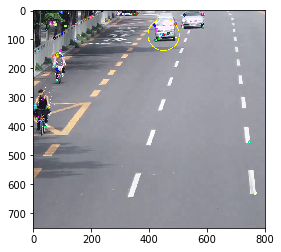

In [10]:
import imutils
import helper_hypercam
def imcrop(img, bbox): 
    x1,y1,x2,y2 = bbox
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = np.pad(img, ((np.abs(np.minimum(0, y1)), np.maximum(y2 - img.shape[0], 0)),
               (np.abs(np.minimum(0, x1)), np.maximum(x2 - img.shape[1], 0)), (0,0)), mode="constant")
    y1 += np.abs(np.minimum(0, y1))
    y2 += np.abs(np.minimum(0, y1))
    x1 += np.abs(np.minimum(0, x1))
    x2 += np.abs(np.minimum(0, x1))
    return img, x1, x2, y1, y2


def Clahe(img):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    if img is not None:
        global count
        #cl1 = clahe.apply(img)
        #cv2.imwrite('clahe_2.jpg',cl1)
        cv2.imwrite("frame%d.jpg" % count, img) 
        #imcrop(frame,(radius,radius,x+radius,y+radius))
        count += 1
    else:
        print("corrupted image detected")

def RunOnce(frame):
    global mask
    global ro
    mask = np.zeros_like(frame)
    figure()
    ro += 1
    
def lineDraw(framel):
    global lines
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(framel,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.imshow("lined_frame",framel)
    
#cap = cv2.VideoCapture('768x576.avi')
cap = cv2.VideoCapture('road5.mp4')
#cap = cv2.VideoCapture(0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2()
count = 0
ro = 0
global mask

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))





# Create a mask image for drawing purposes




while(1):
    ret, frame = cap.read()
    
#    frame = imutils.resize(frame, width=500)
    if not ret:
        break
    # Take first frame and find corners in it  
    frame = imcrop(frame,(400,250,1200,1000))
    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(old_gray,50,150,apertureSize = 3)
    lines = cv2.HoughLines(edges,1,2*pi/180,100)
    
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    framel = frame.copy()
    if ro == 0:
        RunOnce(frame)
        #lineDraw(framel)
        
    

    
    
    
    fgmask = fgbg.apply(frame)

 

    cv2.imshow('frame',fgmask)
    
    cnts = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    center = None
    #x, y, width, height = cv2.boundingRect(cnts[0])
    #roi = frame[y:y+height, x:x+width]
    if len(cnts) > 0:
		# find the largest contour in the mask, then use
		# it to compute the minimum enclosing circle and
		# centroid
      
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
            #center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            center = (x,y) 

		# only proceed if the radius meets a minimum size
            if radius > 50 and radius < 120:
			# draw the circle and centroid on the frame,
			# then update the list of tracked points
                print(radius)
                cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)
                roi = frame[y-50:y+50, x-50:x+50]
                Clahe(roi)
                

                fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                # calculate optical flow
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

                # Select good points
                good_new = p1[st==1]
                good_old = p0[st==1]    
                for i,(new,old) in enumerate(zip(good_new,good_old)):
                    a,b = new.ravel()
                    c,d = old.ravel()
                    mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                    cv2.imshow("Optical Flow lines",mask)
                    frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
                img = cv2.add(frame,mask)
                #cv2.imshow("frame3",img)
                imshow(cv2.cvtColor( img,3))
                show()
                clear_output(wait=True)

                # Now update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1,1,2)  
                
# show the frame to our screen
    cv2.imshow("Frame", frame) 
       
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        

cap.release()
cv2.destroyAllWindows()


In [2]:
%pylab inline 
import cv2
from IPython.display import clear_output

%cd C:\Users\nEW u\Desktop\cv\CASIS-OpenCV-Course-master\data\helperdata

Populating the interactive namespace from numpy and matplotlib
C:\Users\nEW u\Desktop\cv\CASIS-OpenCV-Course-master\data\helperdata


In [7]:
#iteration 2

import imutils
import helper_hypercam
def imcrop(img, bbox): 
    x1,y1,x2,y2 = bbox
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = np.pad(img, ((np.abs(np.minimum(0, y1)), np.maximum(y2 - img.shape[0], 0)),
               (np.abs(np.minimum(0, x1)), np.maximum(x2 - img.shape[1], 0)), (0,0)), mode="constant")
    y1 += np.abs(np.minimum(0, y1))
    y2 += np.abs(np.minimum(0, y1))
    x1 += np.abs(np.minimum(0, x1))
    x2 += np.abs(np.minimum(0, x1))
    return img, x1, x2, y1, y2




def drawCarCountOnImage(carCount,twovehiclecount,m1,fps):
    initText = "Car Counter: "
    text =initText+str(carCount) +  "   Two Wheelers Counter:"+str(     twovehiclecount)+"   FRAME RATE:" + str(int(fps))
    cv2.putText(m1, "Traffic Status: {}".format(text), (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0 ,255), 2)
    cv2.putText(m1, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
        (10, m1.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 255), 1)
    return m1


def millis_interval(start,end):
    """start and end are datetime instances"""
    diff = end - start
    millis = diff.days * 24 * 60 * 60 * 1000
    millis += diff.seconds * 1000
    millis += diff.microseconds / 1000
    return millis


def Clahe(img):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    if img is not None:
        global count
        #cl1 = clahe.apply(img)
        #cv2.imwrite('clahe_2.jpg',cl1)
        cv2.imwrite("frame%d.jpg" % count, img) 
        #imcrop(frame,(radius,radius,x+radius,y+radius))
        count += 1
    else:
        print("corrupted image detected")

def RunOnce(frame):
    global mask
    global ro
    mask = np.zeros_like(frame)
    figure()
    ro += 1
    
def lineDraw(framel):
    global lines
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(framel,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.imshow("lined_frame",framel)
    
#cap = cv2.VideoCapture('768x576.avi')
cap = cv2.VideoCapture('Dashcam.mp4')
#cap = cv2.VideoCapture(0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2()
count = 0
ro = 0
global mask
carCount=0
twovehiclecount=0
blnFirstFrame = True
fps=0
crossingLine=np.zeros((2,2),np.float32)
horizontalLinePosition=434
crossingLine[0][0]= 231
crossingLine[0][1]= horizontalLinePosition
crossingLine[1][0]= 1000
crossingLine[1][1] =horizontalLinePosition




# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))





# Create a mask image for drawing purposes




while(1):
    ret, frame = cap.read()
    
#    frame = imutils.resize(frame, width=500)
    if not ret:
        break
    # Take first frame and find corners in it  
    frame = imcrop(frame,(400,250,1200,1000))
    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(old_gray,50,150,apertureSize = 3)
    lines = cv2.HoughLines(edges,1,2*pi/180,100)
    
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    framel = frame.copy()
    if ro == 0:
        RunOnce(frame)
        #lineDraw(framel)
        
    

    
    
    
    fgmask = fgbg.apply(frame)

 

    cv2.imshow('frame',fgmask)
    
    cnts = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    center = None
    #x, y, width, height = cv2.boundingRect(cnts[0])
    #roi = frame[y:y+height, x:x+width]
    if len(cnts) > 0:
		# find the largest contour in the mask, then use
		# it to compute the minimum enclosing circle and
		# centroid
      
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
            #center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            center = (x,y) 

		# only proceed if the radius meets a minimum size
            if radius > 50:
			# draw the circle and centroid on the frame,
			# then update the list of tracked points
                print(radius)
                cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)
                roi = frame[y-50:y+50, x-50:x+50]
                Clahe(roi)
                

                fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                # calculate optical flow
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

                # Select good points
                good_new = p1[st==1]
                good_old = p0[st==1]    
                for i,(new,old) in enumerate(zip(good_new,good_old)):
                    a,b = new.ravel()
                    c,d = old.ravel()
                    mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                    cv2.imshow("Optical Flow lines",mask)
                    frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
                img = cv2.add(frame,mask)
                #cv2.imshow("frame3",img)
                imshow(cv2.cvtColor( img,3))
                show()
                clear_output(wait=True)

                # Now update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1,1,2)  
                
# show the frame to our screen
   
    cv2.line(frame,(crossingLine[0][0],crossingLine[0][1]),(crossingLine[1][0],crossingLine[1][1]),(0,255,0), 2)
    cv2.imshow("Frame", frame)   
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        

cap.release()
cv2.destroyAllWindows()



ZeroDivisionError: float division by zero

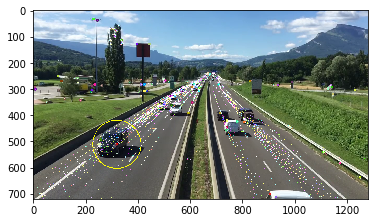

In [3]:
#iteration 2

import imutils
import helper_hypercam
def imcrop(img, bbox): 
    x1,y1,x2,y2 = bbox
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
    img = np.pad(img, ((np.abs(np.minimum(0, y1)), np.maximum(y2 - img.shape[0], 0)),
               (np.abs(np.minimum(0, x1)), np.maximum(x2 - img.shape[1], 0)), (0,0)), mode="constant")
    y1 += np.abs(np.minimum(0, y1))
    y2 += np.abs(np.minimum(0, y1))
    x1 += np.abs(np.minimum(0, x1))
    x2 += np.abs(np.minimum(0, x1))
    return img, x1, x2, y1, y2





def millis_interval(start,end):
    """start and end are datetime instances"""
    diff = end - start
    millis = diff.days * 24 * 60 * 60 * 1000
    millis += diff.seconds * 1000
    millis += diff.microseconds / 1000
    return millis


def Clahe(img):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    if img is not None:
        global count
        #cl1 = clahe.apply(img)
        #cv2.imwrite('clahe_2.jpg',cl1)
        cv2.imwrite("frame%d.jpg" % count, img) 
        #imcrop(frame,(radius,radius,x+radius,y+radius))
        count += 1
    else:
        print("corrupted image detected")

def RunOnce(frame):
    global mask
    global ro
    mask = np.zeros_like(frame)
    figure()
    ro += 1
    

    
#cap = cv2.VideoCapture('768x576.avi')
cap = cv2.VideoCapture('highway.mp4')
#cap = cv2.VideoCapture(0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.createBackgroundSubtractorMOG2()
count = 0
ro = 0
global mask
carCount=0
twovehiclecount=0
blnFirstFrame = True
fps=0
crossingLine=np.zeros((2,2),np.float32)
horizontalLinePosition=434
crossingLine[0][0]= 231
crossingLine[0][1]= horizontalLinePosition
crossingLine[1][0]= 1000
crossingLine[1][1] =horizontalLinePosition




# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))





# Create a mask image for drawing purposes




while(1):
    ret, frame = cap.read()
    
#    frame = imutils.resize(frame, width=500)
    if not ret:
        break
    # Take first frame and find corners in it  
    #frame = imcrop(frame,(400,250,1200,1000))
    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(old_gray,50,150,apertureSize = 3)
    lines = cv2.HoughLines(edges,1,2*pi/180,100)
    
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    framel = frame.copy()
    if ro == 0:
        RunOnce(frame)
        #lineDraw(framel)
        
    

    
    
    
    fgmask = fgbg.apply(frame)

 

    cv2.imshow('frame',fgmask)
    
    cnts = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    center = None
    #x, y, width, height = cv2.boundingRect(cnts[0])
    #roi = frame[y:y+height, x:x+width]
    if len(cnts) > 0:
		# find the largest contour in the mask, then use
		# it to compute the minimum enclosing circle and
		# centroid
      
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
            #center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            center = (x,y) 

		# only proceed if the radius meets a minimum size
            if radius > 50:
			# draw the circle and centroid on the frame,
			# then update the list of tracked points
                #print(radius)
                cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)
                roi = frame[y-50:y+50, x-50:x+50]
                Clahe(roi)
                

                fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                # calculate optical flow
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

                # Select good points
                good_new = p1[st==1]
                good_old = p0[st==1]    
                for i,(new,old) in enumerate(zip(good_new,good_old)):
                    a,b = new.ravel()
                    c,d = old.ravel()
                    mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                    cv2.imshow("Optical Flow lines",mask)
                    frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
                img = cv2.add(frame,mask)
                #cv2.imshow("frame3",img)
                imshow(cv2.cvtColor( img,3))
                show()
                clear_output(wait=True)

                # Now update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1,1,2)  
                
# show the frame to our screen
   
    cv2.line(frame,(crossingLine[0][0],crossingLine[0][1]),(crossingLine[1][0],crossingLine[1][1]),(0,255,0), 2)
    cv2.imshow("Frame", frame)   
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
        

cap.release()
cv2.destroyAllWindows()


In [7]:
import sys


In [9]:
sys.path


['',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\python36.zip',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\DLLs',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib\\site-packages',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32\\lib',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\Pythonwin',
 'c:\\users\\new u\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\nEW u\\AppData\\Roaming\\SPB_16.6\\.ipython']

In [1]:
%pylab inline 
import cv2
from IPython.display import clear_output

%cd C:\Users\nEW u\Desktop\cv\CASIS-OpenCV-Course-master\data

Populating the interactive namespace from numpy and matplotlib
C:\Users\nEW u\Desktop\cv\CASIS-OpenCV-Course-master\data


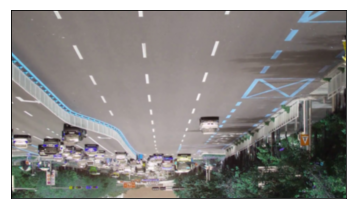

In [5]:
import numpy as np
import imutils
#from firebase1 import firebase
import cv2
import math
import datetime
import matplotlib.pyplot as plt
cap=cv2.VideoCapture('road5.mp4')
#firebase=firebase.FirebaseApplication('https://major-f1a75.firebaseio.com/',None)
#print cap.set(3,640)
#print cap.set(4,480)
cap.set(1,476)
centerPositions=[]
global blobs
blobs=[]
INENTRY=0
OUTENTRY=0
heavy=0
prev=0
prev1=0
#########################################################
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
######################################################################
ret,imgFrame1Copy=cap.read()

mn=imgFrame1Copy
mn=cv2.flip(mn,-1)
#plt.imshow(mn, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
#plt.show()
imgFrame2Copy=imgFrame1Copy

carCount=0
twovehiclecount=0
blnFirstFrame = True
fps=0
###################################################### crossing line reference
crossingLine=np.zeros((2,2),np.float32)
horizontalLinePosition=434
crossingLine[0][0]= 231
crossingLine[0][1]= horizontalLinePosition
crossingLine[1][0]= 1000
crossingLine[1][1] =horizontalLinePosition


while  (True):
    startTime=datetime.datetime.now()
    m1=imgFrame1Copy
    n1=imgFrame2Copy
    m1=cv2.flip(m1,-1)
    n1=cv2.flip(n1,-1)
    masked_image=snipping(m1)
    s1=masked_image
    masked_image=snipping(n1)
    s2=masked_image
    a1 = cv2.cvtColor(s1,cv2.COLOR_BGR2GRAY)
    b1 = cv2.cvtColor(s2,cv2.COLOR_BGR2GRAY)
    a2 = cv2.GaussianBlur(a1,(5,5),0)
    b2 = cv2.GaussianBlur(b1,(5,5),0)
    imgDifference=cv2.absdiff(b2,a2)
    ret1,th1 = cv2.threshold(imgDifference,30,255,cv2.THRESH_BINARY)
    th1 = cv2.dilate(th1,kernel,iterations = 1)
    th1 = cv2.dilate(th1,kernel,iterations = 1)
    fgmask = cv2.erode(th1,kernel,iterations = 1)
    frameNo=cap.get(1)
    fgmask = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel1)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, kernel2)
    fg2=np.zeros((fgmask.shape[0],fgmask.shape[1],3),np.uint8)
    fg3=np.zeros((fgmask.shape[0],fgmask.shape[1],3),np.uint8)
    contours = cv2.findContours(fgmask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    hierarchy = contours 
    contours = numpy.array(contours).reshape((-1,1,2)).astype(numpy.int32)
    cv2.drawContours(fg2, contours, -1, (255,255,255), -1)
    hulls=[]
    for c in range(len(contours)):
        hull=cv2.convexHull(contours[c])
        hulls.append(hull)
    curFrameblobs=[]
    for c in range(len(hulls)):
        ec=blobz(hulls[c])
        if(ec.intCurrentRectArea>100 and ec.dblCurrentDiagonalSize>30 and ec.currentBoundingRect[2]>20 and ec.currentBoundingRect[3]>20 and (ec.currentBoundingArea*1.0/ec.intCurrentRectArea)>.4):
            curFrameblobs.append(ec)
    contor=[]
    for af in curFrameblobs:
        contor.append(af.currentContour)
    if (blnFirstFrame ==True):
        for f1 in curFrameblobs:
            blobs.append(f1)
    else: 
        blobs=matchCurrentFrameBlobsToExistingBlobs(blobs,curFrameblobs)                     
    m1=drawBlobInfoOnImage(blobs,m1)
    atLeastOneBlobCrossedTheLine,carCount,twovehiclecount,INENTRY,OUTENTRY=checkIfBlobsCrossedTheLine(blobs, horizontalLinePosition, carCount,twovehiclecount,INENTRY,OUTENTRY)
    if (atLeastOneBlobCrossedTheLine):
        cv2.line(m1,(crossingLine[0][0],crossingLine[0][1]),(crossingLine[1][0],crossingLine[1][1]),(0,255,0), 2)
    else:
        cv2.line(m1,(crossingLine[0][0],crossingLine[0][1]),(crossingLine[1][0],crossingLine[1][1]),(0,0,255), 2)
    m1=drawCarCountOnImage(carCount,twovehiclecount,m1,fps)
    endTime=datetime.datetime.now()
    millis=millis_interval(startTime,endTime)
    fps=(2.0*1000)/millis
    if INENTRY>prev:
        num1=str(26-INENTRY+OUTENTRY)
#        OUT=firebase.put('/parkinzone','zone1',num1)
    if OUTENTRY>prev1:
        num2=str(26+OUTENTRY-INENTRY)
#        OUT=firebase.put('/parkinzone','zone1',num2)   
    cv2.imshow('original',m1)
    #out.write(m1)
    cv2.drawContours(fg3, contours, -1, (255,255,255), -1)
    cv2.imshow('contour',fg3)
    cv2.drawContours(fg2, hulls, -1, (255,255,255), -1)
    cv2.imshow('convexhulls',fg2)
    prev=INENTRY
    prev1=OUTENTRY
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
    imgFrame1Copy=imgFrame2Copy
    if cap.get(1)==1374:
        cap.set(1,1790)
    if cap.get(1)==2450:
        cap.set(1,3502)
    if cap.get(1)==6302:
        cap.set(1,6400) 
    ret,imgFrame2Copy=cap.read()
    ret,imgFrame2Copy=cap.read()
    ret,imgFrame2Copy=cap.read()
    ret,imgFrame2Copy=cap.read()
    if not ret:
        break
    blnFirstFrame = False
    if cap.get(1)==7000:
        break
    if cap.get(1)==7002:
        break